# <font color="Turquoise"><b>Práctica IV: Segmentación de de imagen</b></font>

# <font color="LightPink"><b>Aplicación Clustering: Segmentación de imagen</b></font>

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/1*8GEXSMN6FyVNBWNBXVAA7A.png
" width="500"/>
</p>

<br>

En esta última parte de la Práctica 3, aplicaremos los algoritmos de `DBSCAN` y `Spectral Clustering` para realizar una **segmentación sobre una imagen RGB**.

El objetivo es analizar:

- La **selección de parámetros** adecuados para cada algoritmo.
- El **costo computacional** asociado a su ejecución, especialmente en contextos de alta dimensionalidad como las imágenes.

Para esta actividad, utilizaremos la imagen `imgflowers.png` como caso de estudio.


In [1]:
#Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

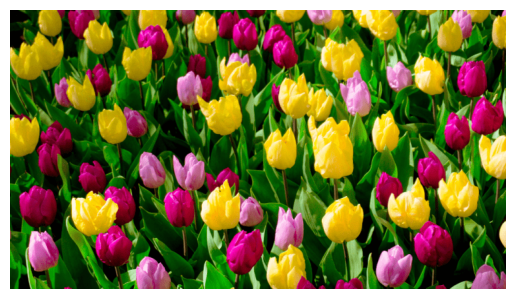

In [4]:
#Leemos la imagen RGB
img = plt.imread('../Datos/imgflowers.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
#Revisemos las dimensiones de los datos
img.shape

(432, 768, 4)

Una imagen a color o **RGB**, como la capturada por nuestros celulares o una cámara convencional, cuenta con **tres canales** (capas o bandas) que capturan respectivamente la información de color rojo <font color="red"><b>(RED)</b></font>, verde <font color="green"><b>(GREEN)</b></font> y azul <font color="blue"><b>(BLUE)</b></font>. A partir de la composición de estos colores se forma una imagen a color.

<br>

**¿Por qué estos canales?**  
Las cámaras convencionales están inspiradas en el **ojo humano**, el cual funciona con base en filtros en estas longitudes de onda.

Dependiendo del formato, la imagen puede contener más información. En este caso, el formato **PNG** tiene un **cuarto canal** correspondiente a valores de referencia para el color negro. **Vamos a trabajar solo con los primeros 3 canales.**

<br>

Adicionalmente, como estamos trabajando con la versión gratuita de Colab, **no tenemos suficiente memoria RAM** que requieren los métodos `DBSCAN` y `Spectral Clustering`. Por lo anterior, vamos a tomar **una parte de la imagen correspondiente a 100x100 píxeles.**

In [6]:
def extraer_seccion_random(imagen, alto=100, ancho=100):
    h, w = imagen.shape[:2]

    y = np.random.randint(0, h - alto + 1)
    x = np.random.randint(0, w - ancho + 1)

    return imagen[y:y+alto, x:x+ancho, 0:3]

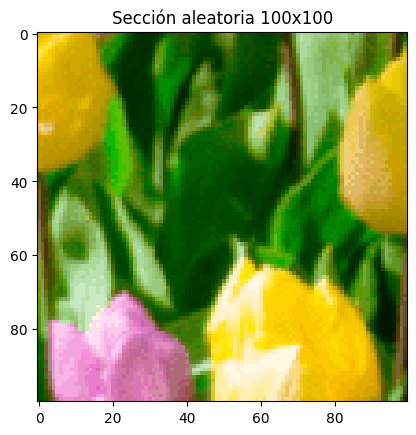

In [7]:
#Visualización de la seccion de imagen
subimg = extraer_seccion_random(img)
plt.imshow(subimg)
plt.title("Sección aleatoria 100x100")
plt.show()

Como podemos observar, la imagen está compuesta por **flores y hojas**. Esperaríamos que un proceso de **segmentación** sea, al menos, capaz de **separar las flores de diferentes colores** y las hojas.

Esto quiere decir que podríamos obtener **al menos 3 clusters** bien diferenciados en la imagen:
1. Hojas o fondo verde
2. Flores de un primer color
3. Flores de un segundo color

Ahora, es necesario organizar los datos de tal forma que podamos emplear los métodos de agrupamiento.

Como recordarán, estos métodos requieren una **matriz de dos dimensiones**, donde:

- Las **filas** corresponden a las **muestras**.
- Las **columnas** corresponden a las **características**.

En el caso de una imagen, nuestras muestras corresponden a los **píxeles**, y las columnas a sus respectivos **valores RGB** (Rojo, Verde y Azul).  
Es decir, cada píxel se representa como un vector de tres dimensiones: `(R, G, B)`.


In [8]:
#Paso 1: Organizamos la matriz de la forma
# 3 x numero de pixeles
data = subimg.transpose(2,0,1).reshape(3,-1)
data.shape

(3, 10000)

In [9]:
#Paso 2: trasponemos obtener la matriz de datos
data = data.transpose(1,0)
data.shape

(10000, 3)

Antes de iniciar el agrupamiento vamos a escalar la imagen de 0 a 1.

In [10]:
#Importamos MaxAbsScaler
from sklearn.preprocessing import MaxAbsScaler
#Escalamos la imagen de 0 a 1
scaler = MaxAbsScaler()
I = scaler.fit_transform(data)

## <font color="LightPink"><b>DBSCAN</b></font>

Vamos a aplicar inicialmente el metodo `DBSCAN` y explorar un poco la selección de los parametros.

In [11]:
#Importamos
from sklearn.cluster import DBSCAN

In [12]:
#Configuramos los parametros
clustering = DBSCAN(eps=0.05, min_samples=10)
#Entrenamos el modelo
clustering.fit(I)
#Obtenemos las etiquetas de pertenencia
y = clustering.labels_

Nota: el metodo de cluster nos entregara la pertenencia de cada pixel a un cluster. Estas etiquetas serán un vector de 1 dimension correspondiente al número de pixeles.

In [13]:
#Revisar tamaño de etiquetas
y.shape

(10000,)

Recordemos que DBSCAN no requiere el número de clusters, estos son calculados automaticamente a partir del los parametros seleccionados.

In [14]:
#Revisar numero de clusters
np.unique(y)
#-1: Corresponde a los puntos de ruido

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114])

Para graficar la segmentación, debemos reconstruir la imagen de 100x100.

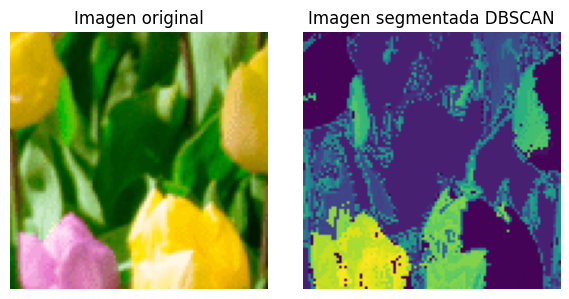

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

#imagen original
axs[0].imshow(subimg)  #subimg: sección original 100x100x3
axs[0].set_title("Imagen original")
axs[0].axis('off')

#imagen segmentada por clustering
clusters_img = y.reshape(100, 100)  #y: etiquetas del clustering
axs[1].imshow(clusters_img)
axs[1].set_title("Imagen segmentada DBSCAN")
axs[1].axis('off')

plt.tight_layout()
plt.show()

Exploremos con diferentes valores de eps y min_samples.

## <font color="LightPink"><b>Spectral Clustering</b></font>

Con `DBSCAN` notamos:

1. Una **alta dificultad para sintonizar los parámetros**.
2. El método es **muy sensible al valor de `eps`**.
3. **No se logra con facilidad segmentar los objetos** principales de la imagen.
4. Sin embargo, es un método **rápido en tiempo de cómputo**.

Ahora vamos a evaluar el comportamiento de `Spectral Clustering` sobre el **mismo conjunto de datos**, para comparar su capacidad de segmentación visual y su costo computacional.


In [16]:
#Importamos
from sklearn.cluster import SpectralClustering

In [17]:
#Configuramos los parametros
clustering = SpectralClustering(n_clusters=3, n_init=10, affinity='rbf', gamma=0.1)
#Entrenamos el modelo
clustering.fit(I)
#Obtenemos las etiquetas de pertenencia
y_SC = clustering.labels_

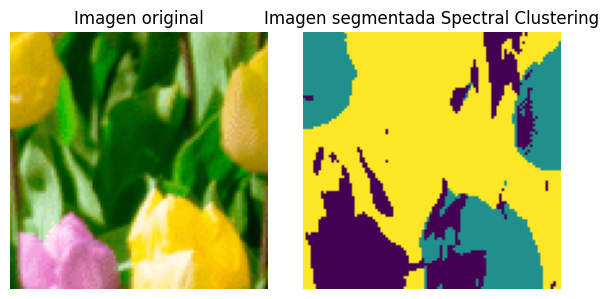

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

#imagen original
axs[0].imshow(subimg)  #subimg: sección original 100x100x3
axs[0].set_title("Imagen original")
axs[0].axis('off')

#imagen segmentada por clustering
clusters_imgSC = y_SC.reshape(100, 100)  #y: etiquetas del clustering
axs[1].imshow(clusters_imgSC)
axs[1].set_title("Imagen segmentada Spectral Clustering")
axs[1].axis('off')

plt.tight_layout()
plt.show()

### <font color="LightPink"><b>Cluster con color del centroide</b></font>

Asignamos a cada píxel el **color promedio RGB** de su cluster, de modo que la imagen segmentada refleje los colores reales de cada grupo y no solo etiquetas numéricas.


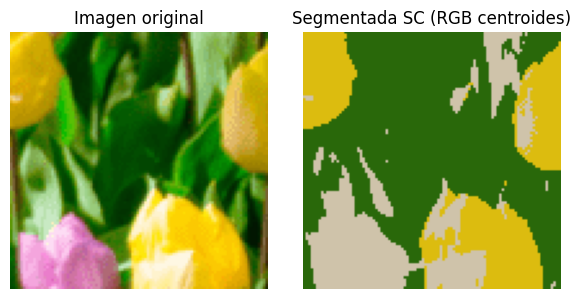

In [19]:
#@title Cluster con color del centroide: construir imagen con colores promedio por cluster

#Inicializamos un array del mismo tamaño que I (pixeles RGB)
img_SC = np.zeros_like(I)

#Para cada etiqueta de cluster, calculamos el color promedio y lo asignamos a los píxeles correspondientes
for label in np.unique(y_SC):
    img_SC[y_SC == label] = I[y_SC == label].mean(axis=0)

#Reconstruimos la imagen 2D de 100x100 con sus 3 canales RGB
img_SC = img_SC.reshape(100, 100, 3)

#Escalamos los valores a [0, 255] si están en el rango [0, 1], y convertimos a tipo uint8
img_SC = (img_SC * 255).astype(np.uint8) if img_SC.max() <= 1.0 else img_SC.astype(np.uint8)

#Mostrar resultados
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(subimg)
axs[0].set_title("Imagen original")
axs[0].axis('off')

axs[1].imshow(img_SC)
axs[1].set_title("Segmentada SC (RGB centroides)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

Exploremos con diferentes numeros de clusters y valores de gamma.

Finalmente, comparemos de forma númerica los resultados obtenidos por DBSCAN y Spectral Clustering.

In [20]:
#Calcular silhouette_score
from sklearn.metrics import silhouette_score

print("Silhouette DBSCAN:", silhouette_score(I, y))
print("Silhouette Spectral Clustering:", silhouette_score(I, y_SC))

Silhouette DBSCAN: 0.4102146625518799
Silhouette Spectral Clustering: 0.5519895553588867
